# Project Overview

## Basic Information

Person or organization developing model: 
*   Abdulrahman Alsadun (abdulrahman.alsadun@gwu.edu), Chao Zhang (chao.zhang@gwu.edu), Elena Huang (mengzhe_huang@gwu.edu), Jenny Yazlovsky (jyazlovsky@gwu.edu), Jinni Yang (jinni.yang@gwu.edu), Maximilian Smith-Uchida (msmithuchida814@gwu.edu)



## Problem Understanding

*   Central Issue: Increase the number of benchmark models SolasAI has access to.

*   Desired Business Outcomes: Build multiple different algorithm types that act as a baseline which can measure disparity: XGBoost, logistic regression, explainable boosting machine, and neural networks models.

*   Client expectations: Different types of models that can be used repeatedly and function as an internal self-check when testing new bias mitigation techniques.


## Risks, Effect, and How to Mitigate Disparity

*   Disparity in a model refers to the systematic error of a model to consistently underestimate or overestimate the true values of a target variable. Some variables will affect the model fit with the model. 

*   Bias can results in unfair outcomes, which perpetuate inequities in our society. Models can become inflexible and cause it to miss essential data or patterns, which leads to inaccurate predictions. It can also cause the model to be incorrect, which can't indicate the relationship between the independent variables and dependent variables. 

*   We should be careful with each variable, regularly check the model's performance and consider the appropriate features or predictors, increase model complexity, or use different modeling techniques.

## Project Goal and Expectation

*   To have a series of models that SolasAI can use in the future as a benchmark for novel bias mitigation methods.


## Included in this notebook:


*   XGBoost, logistic regression, explainable boosting machine, and neural network.
*   Performance metrics 


Fairnesss evaluation notebook: [SAI_Fairness](https://colab.research.google.com/drive/1qnhsBOX10PZVCarttt2DnRb5Nea19ftb?usp=share_link)




# Overall Pipeline 

## Step 0: Install and config

In [ ]:
# mount g-drive with training data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/Shareddrives/SolasPracSpr23/
path = '20221221_simulated_credit_data_w_preds.parquet.gz'

Mounted at /content/gdrive
/content/gdrive/Shareddrives/SolasPracSpr23


In [ ]:
# global settings
REFRESH_XGB = False # set to True to rerun XGB grid search  
REFRESH_NN = False  # set to True to rerun ANN grid search 
NN_REPRO = False     # set to True for single-threaded ANN trainign, slower but should be fully reprodicble
SEED = 12345        # random seed for better reprodubility
CUTOFF = 0.5        # threshold at which prediction decisions are made

In [ ]:
# install versioned dependencies for best reproducibility
! pip install interpret==0.3.2
! pip install h2o==3.40.0.1
! pip install scikit-learn==1.2.2
! pip install pandas==1.4.4
! pip install numpy==1.22.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached interpret-0.3.2-py3-none-any.whl (1.4 kB)
  Using cached interpret_core-0.3.2-py3-none-any.whl (9.1 MB)
  Using cached skope_rules-1.0.1-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 35.8 MB/s eta 0:00:00
  Using cached treeinterpreter-0.2.3-py2.py3-none-any.whl (6.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 87.4 MB/s eta 0:00:00
  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 25.0 MB/s eta 0:00:00
     ━━━━

In [ ]:
# general utilties
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd 
import sklearn
from sklearn import metrics
import numpy as np
import h2o

# plotting
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "svg"

# EBM
import interpret
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

# Logisitc regresion
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# XGBoost
from h2o.estimators import H2OXGBoostEstimator

# Neural Network
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [ ]:
# confirm versions
print("Intepret version:", interpret.__version__)
print("H2o version:", h2o.__version__)
print("Sklearn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)

Intepret version: 0.3.2
H2o version: 3.40.0.1
Sklearn version: 1.2.2
Pandas version: 1.4.4
Numpy version: 1.22.4


In [ ]:
# start h2o 
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.9/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpukej07f1
  JVM stdout: /tmp/tmpukej07f1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpukej07f1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,2 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_3u1gd8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Step 1: Load Data 

In [ ]:
# assign basic modeling roles
y_name = 'Denied'
X_names = ['Mortgage', 'Balance', 'Amount Past Due', 'Delinquency Status', 'Credit Inquiry', 'Open Trade', 'Utilization']
weight_name = ['Sample Weight']
baseline_name = ['Baseline Prediction']
demographic_names = ['Gender', 'Race', 'Age', 'Female', 'Male', 'Minority', 'Majority', 'Age >= 62', 'Age < 62', 'Minority-1-Proportional', 'Minority-2-Proportional', 'Majority-Proportional']

In [ ]:
# load data
df = pd.read_parquet(path)
df['Denied'] = 1-df['Approved']


## Step 2: Partition Data

### Read as Pandas

In [ ]:
# extract train, valid, and test partition
train = df.loc['train', :]
train.reset_index(inplace=True)

valid = df.loc['valid', :]
valid.reset_index(inplace=True)

test = df.loc['test', :]
test.reset_index(inplace=True)

# extract X matrices
train_X = train[X_names]
valid_X = valid[X_names]
test_X = test[X_names]

# extract y matrices
train_y = train[y_name]
valid_y = valid[y_name]
test_y = test[y_name]

# extract sample weights
train_weight = train[weight_name]
valid_weight = valid[weight_name]
test_weight = test[weight_name]

# extract baseline preds
train_base = train[baseline_name]
valid_base = valid[baseline_name]
test_base = test[baseline_name]

# extract demographics
train_demo = train[demographic_names]
valid_demo = valid[demographic_names]
test_demo = test[demographic_names]

### Read as h2o

In [ ]:
# convert to h2o
train_h2o = h2o.H2OFrame(train)
train_h2o[y_name] = train_h2o[y_name].asfactor()

valid_h2o = h2o.H2OFrame(valid)
valid_h2o[y_name] = valid_h2o[y_name].asfactor()

test_h2o = h2o.H2OFrame(test)
test_h2o[y_name] = test_h2o[y_name].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Step 3: Utility functions

In [ ]:
# input variables: model, model_type, train_proba, valid_proba, test_proba
  # model: input one of the models from EBM, LR, XGB, and NN
  # model_type: input a string variable to show up in the column of the output (EX: "EBM")
  # train_proba: input probability predicted for training data
  # valid_proba: input probability predicted for validation data
  # test_proba: input probability predicted for test data

# this funtion will return a table with performance metrics of AUC, RMSE, and Accuracy at 0.5 cutoff

def perf_stats(model, model_type, train_proba, valid_proba, test_proba):

    train_column = model_type+"_train"
    valid_column = model_type+"_valid"
    test_column = model_type+"_test"
    perf = pd.DataFrame(columns=[train_column, valid_column, test_column], index = ['AUC', 'RMSE', 'Accuracy @ 0.5 cutoff'])

    # binary prediction for accuracy score
    train_perf = np.where(train_proba < CUTOFF, 1, 0)
    valid_perf = np.where(valid_proba < CUTOFF, 1, 0)
    test_perf = np.where(test_proba < CUTOFF, 1, 0)

    perf.loc['AUC', train_column, ] = roc_auc_score(train_y, train_proba)
    perf.loc['RMSE', train_column, ] = sqrt(mean_squared_error(train_y,train_proba))
    perf.loc['Accuracy @ 0.5 cutoff', train_column, ] = accuracy_score(train_y,train_perf)

    perf.loc['AUC', valid_column, ] = roc_auc_score(valid_y, valid_proba)
    perf.loc['RMSE', valid_column, ] = sqrt(mean_squared_error(valid_y,valid_proba))
    perf.loc['Accuracy @ 0.5 cutoff', valid_column, ] = accuracy_score(valid_y,valid_perf)

    perf.loc['AUC', test_column, ] = roc_auc_score(test_y, test_proba)
    perf.loc['RMSE', test_column, ] = sqrt(mean_squared_error(test_y,test_proba))
    perf.loc['Accuracy @ 0.5 cutoff', test_column, ] = accuracy_score(test_y,test_perf)

    return perf
    

In [ ]:
# input variables: train_pred, valid_pred, test_pred
  # train_pred: input probability predicted for training data
  # valid_pred: input probability predicted for validation data
  # test_pred: input probability predicted for test data

# this function will provide 3 ROC curve on the same graph

def plot_roc(train_pred, valid_pred, test_pred):

    plt.figure(0).clf()

    # define metrics: train
    fpr, tpr, _ = metrics.roc_curve(train_y,  train_pred)
    auc = metrics.roc_auc_score(train_y, train_pred)
    plt.plot(fpr,tpr,label="Train AUC="+str("%.3f" %auc))

    # define metrics: validation
    fpr, tpr, _ = metrics.roc_curve(valid_y,  valid_pred)
    auc = metrics.roc_auc_score(valid_y, valid_pred)
    plt.plot(fpr,tpr,label="Validation AUC="+str("%.3f"%auc))

    # define metrics: test
    fpr, tpr, _ = metrics.roc_curve(test_y,  test_pred)
    auc = metrics.roc_auc_score(test_y, test_pred)
    plt.plot(fpr,tpr,label="Test AUC="+str("%.3f" %auc))

    # create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    

# Model Pipeline - EBM

## Step 1 and 2: Feature Selection and Hyperparameter Tuning 

In [ ]:
# train EBM with default settings
ebm_model = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm_model.fit(train_X, train_y) 

# typically after a model building process is finished, it's customary to train the final model on all the data,
# using whatever early stopping thresholds were found during cross validation or by found while running against a validation set.
# The EBM framework doesn't really allow for this given that there's always a holdout set and no "refit" of the model without the validation set,
# so there will always be some portion of the data that cannot be used in the final model.

ExplainableBoostingClassifier(n_jobs=-1, random_state=12345)

## Step 3: Score Partitions

In [ ]:
# train scores 
train_ebm_proba = pd.DataFrame(ebm_model.predict_proba(train))
train_ebm_proba = train_ebm_proba[1]

# valid scores
valid_ebm_proba = pd.DataFrame(ebm_model.predict_proba(valid))
valid_ebm_proba = valid_ebm_proba[1]

# test score
test_ebm_proba = pd.DataFrame(ebm_model.predict_proba(test))
test_ebm_proba = test_ebm_proba[1]

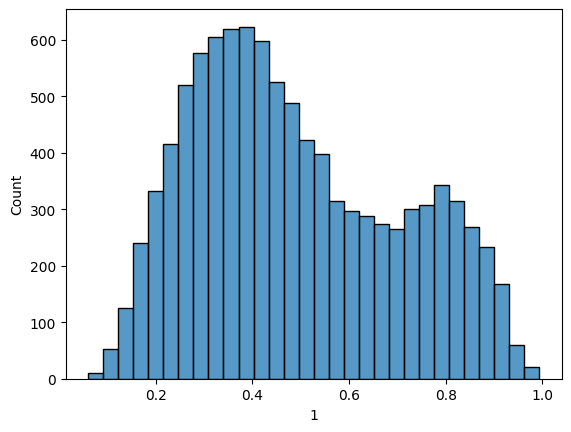

In [ ]:
# histogram of predictions 
_ = sns.histplot(data=test_ebm_proba)

## Step 4: Uniform Performance Statistics

In [ ]:
# performance stats
perf_stats(ebm_model, 'EBM', train_ebm_proba, valid_ebm_proba, test_ebm_proba)

,EBM_train,EBM_valid,EBM_test
AUC,0.748352,0.741603,0.750521
RMSE,0.449853,0.452635,0.449262
Accuracy @ 0.5 cutoff,0.314357,0.31685,0.3185


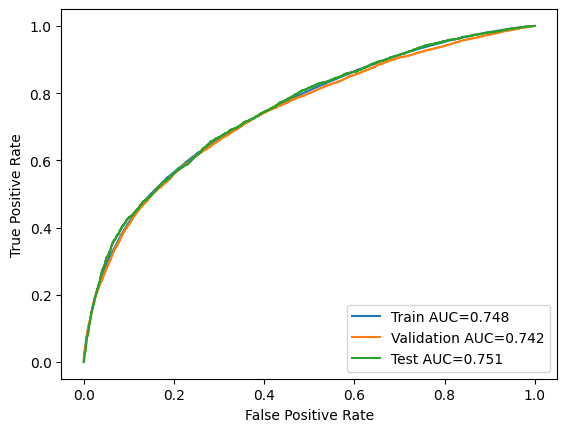

In [ ]:
# ROC curves
plot_roc(train_ebm_proba, valid_ebm_proba, test_ebm_proba)

# Model Pipeline - Logistic Regression

## Step 1 and 2: Feature Selection and Hyperparameter Tuning 

In [ ]:
# initialize traditional logistic regression
lr_model = H2OGeneralizedLinearEstimator(family='binomial',
                                         standardize=True,
                                         compute_p_values = True)

# train 
lr_model.train(X_names, y_name, training_frame=train_h2o)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1682538887819_1


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 2.947E-4 )  7                             7                              3                       py_1_sid_b44a

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21235910528330074
RMSE: 0.46082437574774704
LogLoss: 0.612922079154753
AUC: 0.7209224273799673
AUCPR: 0.7161611266217551
Gini: 0.4418448547599345
Null degrees of freedom: 69999
Residual degrees of freedom: 69992
Null deviance: 97022.42757735393
Residual deviance: 85809.09108166539
AIC: 85825.09108166539

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3493337499933246
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      12790  22774  0.6404   (22774.0/35564.0)
1      4455   29981  0.1294   (4455.0/34436.0)
Total  17245  52755  0.389    (27229.0/70000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349334     0.687709  282
max f2                       0.12939      0.829396  377
max f0point5                 0.530594     0.662452  178
max accuracy                 0.528848     0.660943  179
max precision                0.979762     1         0
max recall                   0.0175521    1         398
max specificity              0.979762     1         0
max absolute_mcc             0.536922     0.328287  175
max min_per_class_accuracy   0.460429     0.657103  215
max mean_per_class_accuracy  0.504414     0.659341  192
max tns                      0.979762     35564     0
max fns                      0.979762     34431     0
max fps                      0.00353263   35564     399
max tps                      0.0175521    34436     398
max tnr                      0.979762     1         0
max fnr                      0.979762     0.999855  0
max fpr                      0.00353263   1         399
max tpr                      0.0175521    1         398

Gains/Lift Table: Avg response rate: 49.19 %, avg score:  2.25 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.0623421          1.40551   1.40551            0.691429         0.0818534  0.691429                    0.0818534           0.0140551       0.0140551                  40.5506   40.5506            0.0079815
2        0.02                        0.0534412          1.35614   1.38082            0.667143         0.057852   0.679286                    0.0698527           0.0135614       0.0276164                  35.6139   38.0822            0.0149913
3        0.03                        0.0468547          1.179     1.31355            0.58             0.0498815  0.64619                     0.0631956           0.01179         0.0394064                  17.8999   31.3548            0.0185145
4        0.04                        0.0437565          1.31548   1.31403            0.647143         0.0451139  0.646429                    0.0586752           0.0131548       0.0525613     

In [ ]:
# coefficient table
lr_model._model_json['output']['coefficients_table']

names,coefficients,std_error,z_value,p_value,standardized_coefficients
Intercept,0.1185326,0.0268871,4.4085246,0.0000104,-0.0136478
Mortgage,-0.0000041,0.0000001,-46.1168568,0.0,-0.4135567
Balance,-0.0002750,0.0000093,-29.5802415,0.0000000,-0.3547258
Amount Past Due,0.0004738,0.0000189,25.0644538,0.0000000,0.2936846
Delinquency Status,0.3126585,0.0071944,43.4585751,0.0,0.5166665
Credit Inquiry,0.1442907,0.0219828,6.5637945,0.0000000,0.0979995
Open Trade,0.0472186,0.0286232,1.6496624,0.0990120,0.0215975
Utilization,1.4672403,0.0356838,41.1178632,0.0,0.4213665


## Step 3: Score Partitions



In [ ]:
# train scores 
train_lr_proba = lr_model.predict(train_h2o).as_data_frame()
train_lr_proba = train_lr_proba.drop(columns=['predict', 'StdErr', 'p0'])

# valid scores
valid_lr_proba = lr_model.predict(valid_h2o).as_data_frame()
valid_lr_proba = valid_lr_proba.drop(columns=['predict', 'StdErr', 'p0'])

# test score
test_lr_proba = lr_model.predict(test_h2o).as_data_frame()
test_lr_proba = test_lr_proba.drop(columns=['predict', 'StdErr', 'p0'])

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


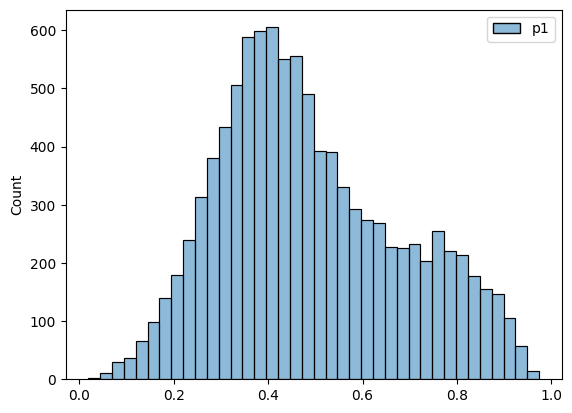

In [ ]:
# histogram of predictions 
_ = sns.histplot(data=test_lr_proba)

## Step 4: Uniform Performance Statistics

In [ ]:
# performance stats
perf_stats(lr_model, 'LR', train_lr_proba, valid_lr_proba, test_lr_proba)

,LR_train,LR_valid,LR_test
AUC,0.720913,0.717687,0.7276
RMSE,0.460824,0.462297,0.458843
Accuracy @ 0.5 cutoff,0.339771,0.34235,0.335


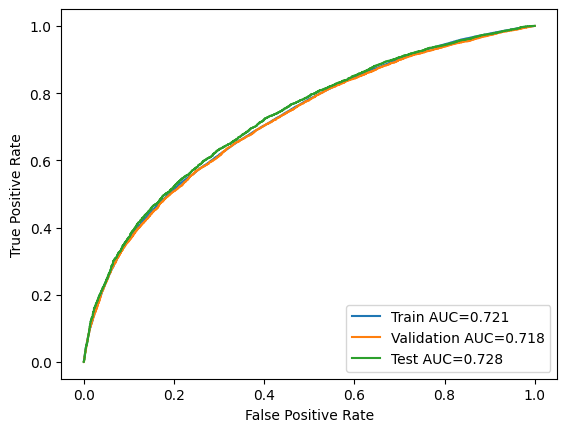

In [ ]:
# ROC curves
plot_roc(train_lr_proba, valid_lr_proba, test_lr_proba)

# Model Pipeline - XGBoost 

## Step 1 and 2: Feature Selection and Hyperparameter Tuning 

In [ ]:
# XGB gridsearch

if REFRESH_XGB:

  # define random grid search parameters
  hyper_parameters = {'ntrees': [500, 1000, 2000],
                      'max_depth': [2, 4, 6], 
                      'min_rows': [1.0, 10], 
                      'sample_rate': [1.0, 0.75, 0.5, 0.25], 
                      'subsample': [1.0, 0.75, 0.5, 0.25]} 

  # define search strategy
  search_criteria = {'strategy':'RandomDiscrete',
                     'max_models':100,
                     'max_runtime_secs':1800}

  # initialize grid search
  gsearch = H2OGridSearch(H2OXGBoostEstimator,
                          hyper_params=hyper_parameters,
                          search_criteria=search_criteria)#,
                          #seed=SEED) # better reproducibility

  # execute training w/ grid search
  gsearch.train(x=X_names,
                y=y_name,
                training_frame=train_h2o,
                validation_frame=valid_h2o, 
                stopping_rounds=20,
                seed=SEED) # better reproducibility


In [ ]:
if REFRESH_XGB:
  
  # Get the grid results, sorted by validation AUC
  gridperf = gsearch.get_grid(sort_by='auc', decreasing=True)

  # Grab the top model, chosen by validation AUC
  best_xgb = gridperf.models[0] 

  # This generates the exact parameters for the best model
  print(best_xgb.get_params())

  del gsearch # grid search object is large

In [ ]:
if REFRESH_XGB:
  
  # build and train the model using parameters found above:
  # whatever comes from get_params() goes here to parameterize this model

  # gitting the the params of the best model
  xgb_params = best_xgb.get_params()

  # assign the best params to the model and training it
  xgb_model = H2OXGBoostEstimator( **xgb_params)

  xgb_model.train(x=X_names,
                  y=y_name,
                  training_frame=train_h2o,
                  validation_frame=valid_h2o)

## Step 3: Score Partitions

In [ ]:
# train scores 
train_xgb_proba = xgb_model.predict(train_h2o).as_data_frame()
train_xgb_proba = train_xgb_proba.drop(columns=['predict', 'p0'])

# valid scores
valid_xgb_proba = xgb_model.predict(valid_h2o).as_data_frame()
valid_xgb_proba = valid_xgb_proba.drop(columns=['predict', 'p0'])

# test score
test_xgb_proba = xgb_model.predict(test_h2o).as_data_frame() 
test_xgb_proba = test_xgb_proba.drop(columns=['predict', 'p0'])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


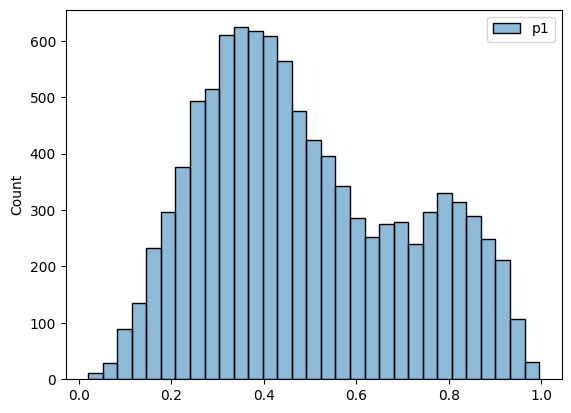

In [ ]:
# histogram of predictions 
_ = sns.histplot(data=test_xgb_proba)

## Step 4: Uniform Performance Statistics

In [ ]:
# performance stats
perf_stats(xgb_model, 'XGB', train_xgb_proba, valid_xgb_proba, test_xgb_proba)

,XGB_train,XGB_valid,XGB_test
AUC,0.764274,0.738303,0.745395
RMSE,0.443259,0.454203,0.45122
Accuracy @ 0.5 cutoff,0.303443,0.32035,0.3216


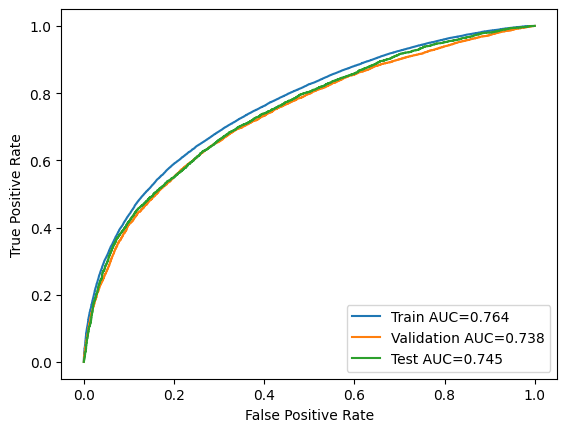

In [ ]:
# ROC curves
plot_roc(train_xgb_proba, valid_xgb_proba, test_xgb_proba)

# Model Pipeline - Neural Network 

## Step 1 and 2: Feature Selection and Hyperparameter Tuning 

In [ ]:
if REFRESH_NN: 

  # define random grid search parameters
  hyper_parameters = {'hidden': [[10], [50, 50], [25, 25, 25, 25], [100, 50], [50, 100], [100, 50, 25], [100, 100]],
                      'l1':[s/1e4 for s in range(0, 1000, 100)],
                      'l2':[s/1e5 for s in range(0, 1000, 100)],
                      'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

  # define search strategy
  search_criteria = {'strategy':'RandomDiscrete',
                    'max_models':100,
                    'max_runtime_secs':1800}

  # initialize grid search
  gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                          hyper_params=hyper_parameters,
                          search_criteria=search_criteria)#,
                          #seed=SEED) # better reproducibility

  # execute training w/ grid search
  gsearch.train(x=X_names,
                y=y_name,
                training_frame=train_h2o,
                validation_frame=valid_h2o, 
                activation="Tanh",
                epochs=8000, 
                stopping_rounds=20,                    
                ignore_const_cols=True,              
                adaptive_rate=True,
                seed=SEED) # better reproducibility

In [ ]:
if REFRESH_NN: 

  # Get the grid results, sorted by validation AUC
  gridperf = gsearch.get_grid(sort_by='auc', decreasing=True)

  # Grab the top model, chosen by validation AUC
  best_nn = gridperf.models[0] 

  # This generates the exact parameters for the best model
  print(best_nn.get_params())

  del gsearch # grid search object is large

In [ ]:
if REFRESH_NN: 

  # build and train the model using parameters found above:
  # whatever comes from get_params() goes here to parameterize this model

  # gitting the the params of the best model
  nn_params = best_nn.get_params()

  # assign the best params to the model and training it
  nn_model = H2ODeepLearningEstimator( **nn_params)

  nn_model.train(x=X_names,
                y=y_name,
                training_frame=train_h2o, 
                validation_frame=valid_h2o) 

## Step 3: Score Partitions

In [ ]:
# train scores 
train_nn_proba = nn_model.predict(train_h2o).as_data_frame()
train_nn_proba = train_nn_proba.drop(columns=['predict', 'p0'])

# valid scores
valid_nn_proba = nn_model.predict(valid_h2o).as_data_frame()
valid_nn_proba = valid_nn_proba.drop(columns=['predict', 'p0'])

# test score
test_nn_proba = nn_model.predict(test_h2o).as_data_frame()
test_nn_proba = test_nn_proba.drop(columns=['predict', 'p0'])

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


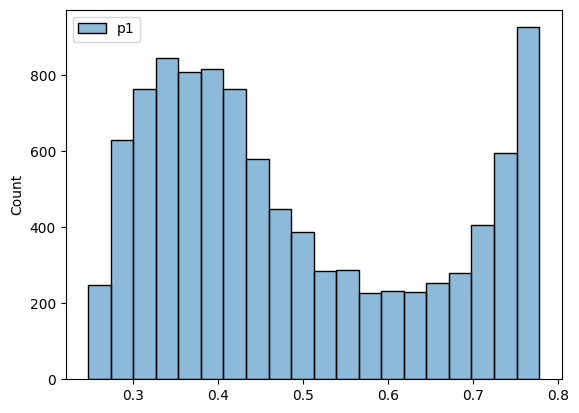

In [ ]:
# histogram of predictions 
_ = sns.histplot(data=test_nn_proba)

## Step 4: Uniform Performance Statistics

In [ ]:
# performance stats
perf_stats(nn_model, 'NN', train_nn_proba, valid_nn_proba, test_nn_proba)

,NN_train,NN_valid,NN_test
AUC,0.720296,0.718056,0.72808
RMSE,0.463129,0.463717,0.461361
Accuracy @ 0.5 cutoff,0.336171,0.3379,0.3347


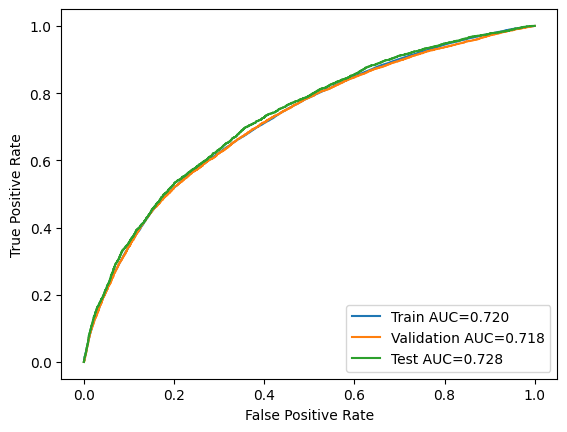

In [ ]:
# ROC curves
plot_roc(train_nn_proba, valid_nn_proba, test_nn_proba)

In [ ]:
# shutdown H2O
h2o.shutdown()

H2O session _sid_b44a closed.


<ipython-input-49-effe4d6b351a>:2: H2ODeprecationWarning:

Deprecated, use ``h2o.cluster().shutdown()``.



# Performance Evaluation

In [ ]:
# add predictions to train dataset
train['EBM Prediction'] = train_ebm_proba  # add EBM model's predicted probabilities to train dataset
train['EBM Offer'] = np.where(train_ebm_proba < CUTOFF, 1, 0) # create binary column for EBM model's predicted offers
train['LR Prediction'] = train_lr_proba # add LR model's predicted probabilities to train dataset
train['LR Offer'] = np.where(train_lr_proba < CUTOFF, 1, 0) # create binary column for LR model's predicted offers
train['XGB Prediction'] = train_xgb_proba # add XGB model's predicted probabilities to train dataset
train['XGB Offer'] = np.where(train_xgb_proba < CUTOFF, 1, 0) # create binary column for XGB model's predicted offers
train['NN Prediction'] = train_nn_proba # add NN model's predicted probabilities to train dataset
train['NN Offer'] = np.where(train_nn_proba < CUTOFF, 1, 0) # create binary column for NN model's predicted offers

# add predictions to valid dataset
valid['EBM Prediction'] = valid_ebm_proba
valid['EBM Offer'] = np.where(valid_ebm_proba < CUTOFF, 1, 0)
valid['LR Prediction'] = valid_lr_proba
valid['LR Offer'] = np.where(valid_lr_proba < CUTOFF, 1, 0)
valid['XGB Prediction'] = valid_xgb_proba
valid['XGB Offer'] = np.where(valid_xgb_proba < CUTOFF, 1, 0)
valid['NN Prediction'] = valid_nn_proba
valid['NN Offer'] = np.where(valid_nn_proba < CUTOFF, 1, 0)

# add predictions to test dataset
test['EBM Prediction'] = test_ebm_proba
test['EBM Offer'] = np.where(test_ebm_proba < CUTOFF, 1, 0)
test['LR Prediction'] = test_lr_proba
test['LR Offer'] = np.where(test_lr_proba < CUTOFF, 1, 0)
test['XGB Prediction'] = test_xgb_proba
test['XGB Offer'] = np.where(test_xgb_proba < CUTOFF, 1, 0)
test['NN Prediction'] = test_nn_proba
test['NN Offer'] = np.where(test_nn_proba < CUTOFF, 1, 0)

<ipython-input-50-d6dd67bd13c0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-d6dd67bd13c0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-d6dd67bd13c0>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-d6dd67b

In [ ]:
# run once for converting results to csv files
train.to_csv("train_predicted.csv")
valid.to_csv("valid_predicted.csv")
test.to_csv("test_predicted.csv")

In [ ]:
# compare with baseline scores
perf = pd.DataFrame(columns=['EBM', 'LR', 'XGB', 'NN'], index = ['AUC', 'RMSE', 'Accuracy @ 0.5 cutoff'])

ebm_perf = np.where(test_ebm_proba < CUTOFF, 1, 0) # calculate performance for EBM model
lr_perf = np.where(test_lr_proba < CUTOFF, 1, 0)  # calculate performance for LR model
xgb_perf = np.where(test_xgb_proba < CUTOFF, 1, 0) # calculate performance for XGB model
nn_perf = np.where(test_nn_proba < CUTOFF, 1, 0) # calculate performance for NN model

# calculate AUC, RMSE, and accuracy for each model and add to perf dataframe for EBM
perf.loc['AUC', 'EBM', ] = roc_auc_score(test_y, test_ebm_proba) 
perf.loc['RMSE', 'EBM', ] = sqrt(mean_squared_error(test_y,test_ebm_proba))
perf.loc['Accuracy @ 0.5 cutoff', 'EBM', ] = accuracy_score(test_y,ebm_perf) 

# calculate AUC, RMSE, and accuracy for each model and add to perf dataframe for LR
perf.loc['AUC', 'LR', ] = roc_auc_score(test_y, test_lr_proba)
perf.loc['RMSE', 'LR', ] = sqrt(mean_squared_error(test_y,test_lr_proba))
perf.loc['Accuracy @ 0.5 cutoff', 'LR', ] = accuracy_score(test_y,lr_perf) 

# calculate AUC, RMSE, and accuracy for each model and add to perf dataframe for XGB
perf.loc['AUC', 'XGB', ] = roc_auc_score(test_y, test_xgb_proba)
perf.loc['RMSE', 'XGB', ] = sqrt(mean_squared_error(test_y,test_xgb_proba))
perf.loc['Accuracy @ 0.5 cutoff', 'XGB', ] = accuracy_score(test_y,xgb_perf) 

# calculate AUC, RMSE, and accuracy for each model and add to perf dataframe for NN
perf.loc['AUC', 'NN', ] = roc_auc_score(test_y, test_nn_proba)
perf.loc['RMSE', 'NN', ] = sqrt(mean_squared_error(test_y,test_nn_proba))
perf.loc['Accuracy @ 0.5 cutoff', 'NN', ] = accuracy_score(test_y,nn_perf) 
perf

,EBM,LR,XGB,NN
AUC,0.750521,0.7276,0.745395,0.72808
RMSE,0.449262,0.458843,0.45122,0.461361
Accuracy @ 0.5 cutoff,0.3185,0.335,0.3216,0.3347
